# Overview

This report details the steps of the analysis I performed to build a model capable of classifing the digits in test.csv.

The section Introduction is a high level recap of the whole analysis and its main takeaways.

The sections after Introduction report the analysis itself with the code and additional comments that explain the rationale of each choice.

The section Conclusion at the end of the document recaps the final outcome of this analysis, including ideas regarding possible improvements to this work.

# Introduction


The first step of my analysis (section "Data Exploration") was a visual and qualitative exploration of the 2 datasets train.csv and test.csv, the former having labeled images, the latter having images with unknown classification. The main outcome of this preliminary exploration was that images in train.csv seemed to be quite noisy and all classes were equally represented. Also, images in train.csv seemed to be similar to those in test.csv, meaning that it is reasonable to expect that a classifier trained on train.csv should be able to correctly classify images on test.csv.   

To select the best model for the final prediction on test.csv, I splitted the labeled data of train.csv into a training and a test set. This allowed me to perform model selection based on their performance on the test set.

Upon this preliminary exploration, I followed a "phased" approach, i.e. I considered first less sophisticated models, and gradually introduced more sophisticated ones. I then selected only the most performing/better behaving (e.g. with a regular decreasing loss function) ones.

In particular I tried the following approaches - more details about each attempt can be found in dedicate sections in this document:

\begin{enumerate}
	\item SVM along with PCA and without PCA - it turned out that SVM with radial kernel and no PCA was the most performant SVM-like model
	\item Simple CNN - a simple CNN with 2 convolutional layers was built and trained on both the training set and on an augmented version of the training set; the augmented dataset turned out to lead to poor performances and slow training
	\item Transfer learning with VGG16 and its weights from ImageNet - this attempt led to very poor results, most likely because the images from ImageNet are characterized by features too different from our dataset, so even this attempt was dropped
    \item Alternative CNN Architecture - I built a slightly more complex CNN with 4 convolutional layers (rather than 2 as in the CNN at point 2) and trained it with and without Data Augmentation; even in this case Data Augmentation led to poor results meaning that in addition to low accuracy, the shape of the loss function had a very irregular path
\end{enumerate}


The CNN described at point 4 above (without Data Augmentation) turned out to have the best prediction accuracy on the test set and a nice loss function plot. This CNN was then used to classify images on test.csv.

# Data exploration

In this section we performed a visual and qualitative exploration of the datasets from https://www.kaggle.com/c/dsti-s20-ann/data.

As per Kaggle description, the dataset is made of train.csv and test.csv, each of them having 28x28 greyscale images flattened into a 784-elements array. 

train.csv contains also the target variable and is made of 12000 images.

test.csv is made of 50000 images, with no target variable.

The main take-aways from this inspection are that:

\begin{itemize}
\item pixels are alreay rescaled to take values between [0,1]
\item train.csv is balanced in terms of represented classes
\item train.csv and test.csv have a similar content, i.e. train.csv should allow to build a model that can perform well on test.csv
\end{itemize}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

# use seaborn plotting defaults
import seaborn as sns; sns.set()

%matplotlib inline

In [2]:
# load the data set where labels are known
dataset = pd.read_csv("train_data.csv", header = None)

dataset.shape

(12000, 785)

Check if all values in dataset are scaled within [0,1].

This is needed for example by SVM given that SVM is not scale-invariant, as reported on the scikitlearn reference webpage.

In [11]:
def checkVals(inputDF: pd.DataFrame):
    """
    This function checks whether the values of a dataframe are within the interval 0,1.
    If yes, returns True, otherwise returns False
    
    Input:
        - inputDF: input dataframe
        
    Output:
        - outcome:
            - True: if values of inputDF are all within [0,1]
            - False: otherwise
    
    """
    
    outcome = False
    
    ######## extract the min and max from each cols ########
    
    lowest = inputDF.describe().loc["min",:].min()
    
    highest = inputDF.describe().loc["max",:].max()
    
    if lowest >= 0 and highest <= 1:
        outcome = True
        
    return outcome
    

In [12]:
# check if pixel values are normalized
print(f"Pixels values are normalized with values within [0,1] ? {checkVals(dataset.drop(784, axis = 1))}")

Pixels values are normalized with values within [0,1] ? True


Check whether all classes are equally represented in train.csv.

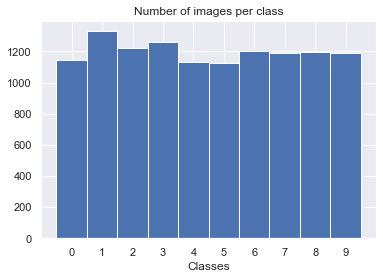

In [6]:
plt.hist(dataset.iloc[:,784], bins=range(11), align='left')
plt.xticks(range(10))
plt.title("Number of images per class")
plt.xlabel("Classes")
plt.show()

The histogram shows that classes are equally distributed.

We now transform our data set in a numpy matrix

In [7]:
# from dataframe to numpy
datasetNumpy = dataset.to_numpy(copy = True)

datasetNumpy.shape

(12000, 785)

In [8]:
# extract pixel values without the class
datasetData = datasetNumpy[:,range(0,datasetNumpy.shape[1]-1)]

datasetData.shape

(12000, 784)

In [9]:
# extract classes
datasetTarget = datasetNumpy[:,datasetNumpy.shape[1]-1]

# flatten to 1D array + cast to integer
datasetTarget = datasetTarget.flatten().astype(int)

print(type(datasetTarget))
print(datasetTarget.shape)
print(datasetTarget[:2,])

<class 'numpy.ndarray'>
(12000,)
[5 7]


Check if pixels in test.csv are scaled.

In [17]:
# load the validation set
val = pd.read_csv("test_data.csv", header = None)

# check if pixel values are normalized
print(f"Pixels values are normalized with values within [0,1] ? {checkVals(val)}")

Pixels values are normalized with values within [0,1] ? True


In [18]:
val.shape

(50000, 784)

In [19]:
# transform in numpy array
val = val.to_numpy(copy = True)

Create list of numpy 2D array, each of them being an image and display some of them from the training set to visually inspect them.

In [20]:
def displayImgFromNumpy(inputNumpyArr, height, width, targetVar = None):
    """
    This function displays on a grid 2 x 3 the first 6 images included in the input numpy array
    
    Input:
        - inputNumpyArr: input numpy array where each row is the flattened version of the image
        - height: height of the image to be displayed
        - width: width of the image to be displayed
        - targetVar: 1D numpy array that has the classes
        
    Output:
        - print the plot
    """
    imgList = [inputNumpyArr[i,:].reshape(height,width) for i in range(0,inputNumpyArr.shape[0])]
    
    fig, ax = plt.subplots(2, 3)
    for i, axi in enumerate(ax.flat):
        axi.imshow(imgList[i], cmap='bone')
        if targetVar is not None: axi.set(xticks=[], yticks=[], xlabel= targetVar[i])
            
        else: axi.set(xticks=[], yticks=[])
    

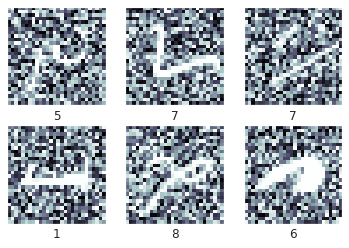

In [21]:
# images from the training set
displayImgFromNumpy(datasetData,28,28,datasetTarget)

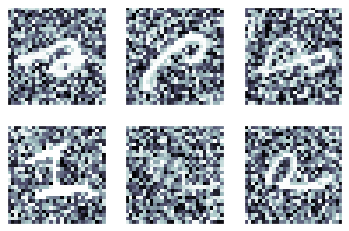

In [22]:
# images from the test.csv
displayImgFromNumpy(val,28,28)

Images from the training and the test set seem to be very noisy. 

Also, images from the training set seem to be close to images from the test set.

Split the Dataset train.csv in Training and Test set, each of them obtained as 75 % and 25% respectively from train.csv.

In [10]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(datasetData, datasetTarget, random_state=42)

In [11]:
Xtrain.shape

(9000, 784)

In [12]:
np.histogram(ytrain, bins = np.arange(0,11))

(array([840, 979, 932, 915, 853, 850, 920, 903, 888, 920], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

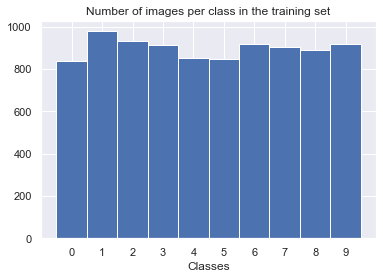

In [14]:
plt.hist(ytrain, bins=range(11), align='left')
plt.xticks(range(10))
plt.title("Number of images per class in the training set")
plt.xlabel("Classes")
plt.show()

From the above we see that the training set is quite balanced in terms of classes.

# PCA and SVM

Before considering a Neural Network, I will build an SVM model. 

Given that each image is made of 768 pixel and the training set has 12000 * 0.75 = 9000 images (which means # individuals / # features approx equal to 10) I will run a PCA to reduce the number of features.

I will consider both a radial and a linear kernel, and finally select the one with the best precision on the test set.

The main takeway from this analysis is that the overall recall (i.e. total number of correct predictions over total number of observations) is slightly higher for the linear kernel.

Also it looks like the most critical digits to be classified are 5 (often wrongly classified often as 0,3,8), 8 (often wrongly classified often as 1,2,3,5) and 9 (often classified as 4).

## Radial kernel

In [ ]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized')
svc = SVC(kernel='rbf', class_weight='balanced', cache_size = 1000)
model = make_pipeline(pca, svc)

Cross validation for the parameters C of SVM and gamma for the kernel.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 17min 30s, sys: 1min 31s, total: 19min 2s
Wall time: 14min 44s
{'svc__C': 10, 'svc__gamma': 0.005}


Given that the above cross-validation returned gamma = 0.005 which is the max value that was tested during the grid search, I perform an additional grid search extending the values of gamma to 0.05

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [10],
              'svc__gamma': [0.005, 0.01, 0.05]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 13min 50s, sys: 17.5 s, total: 14min 7s
Wall time: 13min 17s
{'svc__C': 10, 'svc__gamma': 0.005}


In [ ]:
model_rad = grid.best_estimator_
yfit_rad = model_rad.predict(Xtest)

### Assess performances

We check below some example of: 

- correct classification ==> marked with black label
- wrong classifications ==> marked with red label

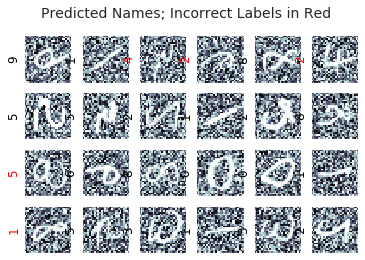

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i,:].reshape(28, 28), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(yfit_rad[i], color='black' if yfit_rad[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit_rad))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       306
           1       0.85      0.91      0.88       351
           2       0.72      0.82      0.76       287
           3       0.76      0.77      0.77       348
           4       0.76      0.80      0.78       278
           5       0.66      0.68      0.67       277
           6       0.84      0.80      0.82       285
           7       0.85      0.79      0.82       290
           8       0.80      0.65      0.72       306
           9       0.74      0.67      0.70       272

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit_rad)

print(mat)

[[275   0   3   2   0  16   5   0   3   2]
 [  0 320   7   4   0   4   2   4   9   1]
 [  8   7 234   6   6   2   7   6   9   2]
 [  1   6  18 267   3  28   5   5   8   7]
 [  1   3  12   3 223   3   7   2   1  23]
 [ 18   7   5  28   6 189   7   2   8   7]
 [ 14   3  18   4   2  11 228   1   3   1]
 [  4  12   9   2   9   4   1 230   3  16]
 [  6  20  18  22   7  21   6   1 199   6]
 [  2   0   3  12  39   8   2  19   5 182]]


From the above we see that 5, 8, 9 are the most problematic digits to identify.

Overall Recall computed as number of correct predictions divided by the total number of observations is 79 %.

In [ ]:
np.trace(mat)/ len(ytest)

0.7903333333333333

## Linear kernel

We follow here the same steps as for the radial kernel, of course with some minor change related to the fact we are using the linear kernel

In [ ]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized')
svc = SVC(kernel='linear', class_weight='balanced', cache_size = 1000)
model = make_pipeline(pca, svc)

Cross validation for the parameters C of SVM.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50] } #, 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 25min 26s, sys: 23.6 s, total: 25min 50s
Wall time: 24min 44s
{'svc__C': 1}


In [ ]:
model_lin = grid.best_estimator_
yfit_lin = model_lin.predict(Xtest)

### Assess performances

We check below some example of: 

- correct classification ==> marked with black label
- wrong classifications ==> marked with red label

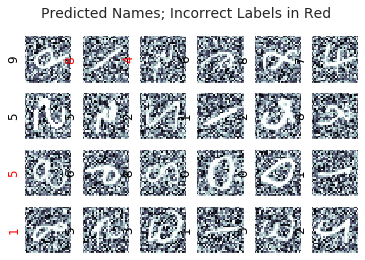

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i,:].reshape(28, 28), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(yfit_lin[i], color='black' if yfit_lin[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit_lin))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       306
           1       0.86      0.91      0.88       351
           2       0.74      0.82      0.78       287
           3       0.76      0.78      0.77       348
           4       0.78      0.82      0.80       278
           5       0.67      0.70      0.68       277
           6       0.84      0.81      0.82       285
           7       0.84      0.80      0.82       290
           8       0.79      0.65      0.71       306
           9       0.76      0.69      0.72       272

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit_lin)

print(mat)

[[276   0   3   3   0  11   8   1   3   1]
 [  0 318   8   4   0   5   1   4  10   1]
 [  7   6 235   5   6   3   8   5  10   2]
 [  2   6  17 270   3  28   5   3   7   7]
 [  1   2   8   2 229   2   7   3   1  23]
 [ 15   4   4  29   6 195   7   2  10   5]
 [ 13   2  14   4   2  14 231   1   3   1]
 [  4  12  10   3  10   3   1 232   4  11]
 [  5  20  16  21   7  23   6   3 198   7]
 [  2   0   1  12  31   9   2  23   5 187]]


Even with the linear kernel we see that 5, 8, 9 are the most problematic digits to identify.


Overall Recall computed as number of correct predictions divided by the total number of observations is 79 %.

In [ ]:
np.trace(mat)/ len(ytest)

0.7903333333333333

## Compare precision and recall of SVM Linear VS Radial

In this section we compare the precision of SVM when using the linear VS radial kernel.

In [ ]:
def extractPrecision(yTestSet, yFit, metric):
    """
    This function returns a list with the precision of predictions for each class:
    
    Input:
        - yTestSet: numpy array with the real value of the class for each entry in the test set
        - yFit: numpy array with the predicted value of the class for each entry in the test set
        - metric: either precision or recall
    
    """
    
    class_report = classification_report(yTestSet, yFit, output_dict= True)
    
    # create a list of the precision for each class from 0 to 9
    return [round(class_report[i][metric],2) for i in map(str, range(9 + 1))]

In [ ]:
def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


In [ ]:
def comparePrecision(yTestSet, yFit1, yFit2, nameAlgo1, nameAlgo2, metric):
    """
    This function draws in the same histogram the precision of the predictions of 2 models for each class from 0 to 9
    
    Input:
        - yTestSet: numpy array with the real value of the class for each entry in the test set
        - yFit1, yFit2: numpy array with the predicted value of the class for each entry in the test set from 2 different models    
        - nameAlgo1, nameAlgo2 - name of the models being compared - this names will be displayed in the barplot legenda
    
    """
    
    # extract precision for predictions on each class
    precision1 = extractPrecision(yTestSet, yFit1, metric)
    precision2 = extractPrecision(yTestSet, yFit2, metric)
    
    labels = [i for i in range(0,10)]
    
    x = np.arange(len(labels))  # the label locations
    width = 0.40  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,5))
    rects1 = ax.bar(x - width/2, precision1, width, label = nameAlgo1)
    rects2 = ax.bar(x + width/2, precision2, width, label = nameAlgo2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(metric)
    ax.set_ylim(ymin = 0.5, ymax = 1)
    ax.set_title( nameAlgo1 + ' VS ' + nameAlgo2 + ' - ' + metric)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="best")
        

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()
    

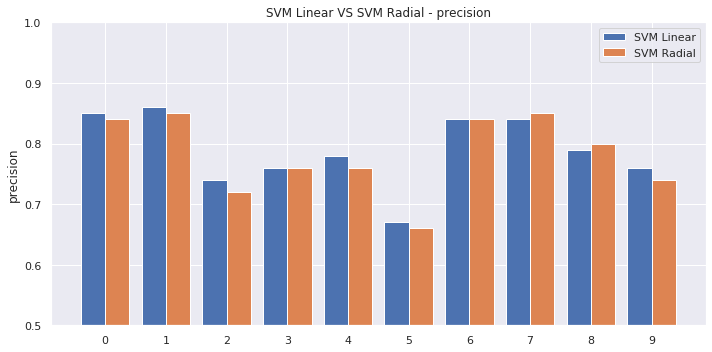

In [ ]:
comparePrecision(ytest, yfit_lin, yfit_rad, "SVM Linear", "SVM Radial", "precision")

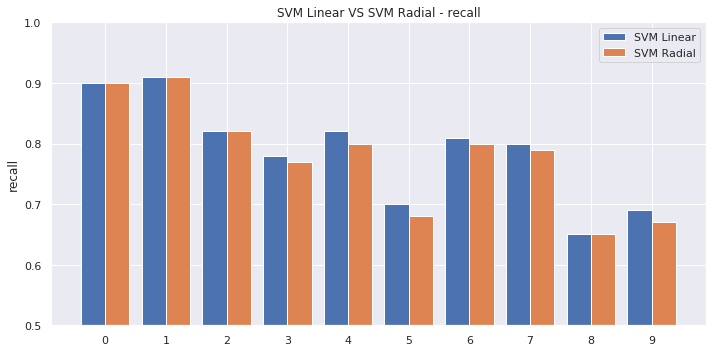

In [ ]:
comparePrecision(ytest, yfit_lin, yfit_rad, "SVM Linear", "SVM Radial", "recall")

The SVM with linear or radial kernels seem to have similar performances.

# SVM no PCA

Given the results obtained using PCA were not very satisfactory, I now run SVM without PCA.

The main takeaway of this section is that SVM with radial Kernel has better performance than other SVM-based algos that we tested (with or without PCA).

The digits 5 8 9 are still the most difficult to be classified.

## Radial kernel

In [ ]:
#pca = RandomizedPCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized')
modelSVM_noPCA = SVC(kernel='rbf', class_weight='balanced', cache_size = 1000)
#model = make_pipeline(pca, svc)

Cross validation for the parameters C and gamma for the radial kernel of SVM.

In [ ]:
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(modelSVM_noPCA, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1h 9min 23s, sys: 419 ms, total: 1h 9min 23s
Wall time: 1h 9min 23s
{'C': 1, 'gamma': 0.005}


Need to further explore lower values for C and higher values for gamma.

In [ ]:
param_grid = {'C': [0.8, 0.9, 1],
              'gamma': [0.005, 0.01]}
grid = GridSearchCV(modelSVM_noPCA, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 27min 26s, sys: 148 ms, total: 27min 26s
Wall time: 27min 26s
{'C': 0.8, 'gamma': 0.01}


In [ ]:
param_grid = {'C': [0.4, 0.6, 0.8],
              'gamma': [0.005, 0.01, 0.05]}
grid = GridSearchCV(modelSVM_noPCA, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 54min 12s, sys: 295 ms, total: 54min 12s
Wall time: 54min 12s
{'C': 0.8, 'gamma': 0.01}


### Assess performance

In [ ]:
model_rad_no_PCA = grid.best_estimator_
yfit_rad_no_PCA = model_rad_no_PCA.predict(Xtest)

In [ ]:
print(classification_report(ytest, yfit_rad_no_PCA))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       306
           1       0.88      0.97      0.92       351
           2       0.83      0.83      0.83       287
           3       0.84      0.78      0.81       348
           4       0.79      0.83      0.81       278
           5       0.71      0.80      0.75       277
           6       0.86      0.87      0.86       285
           7       0.88      0.82      0.85       290
           8       0.83      0.70      0.76       306
           9       0.75      0.77      0.76       272

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



In [ ]:
mat = confusion_matrix(ytest, yfit_rad_no_PCA)

print(mat)

[[282   0   5   2   0   5   7   1   3   1]
 [  0 341   2   1   0   2   2   2   1   0]
 [  3   6 237   6   7   5   6   7  10   0]
 [  1   5  11 272   1  29   8   6   9   6]
 [  0   5   4   0 232   0   5   2   4  26]
 [  4   2   5  19   7 221   6   0   6   7]
 [  4   0   8   2   1  17 247   1   3   2]
 [  3   9   8   0  10   0   1 239   3  17]
 [  1  18   7  17   6  27   5   0 215  10]
 [  1   1   0   5  31   5   1  15   4 209]]


Overall Recall computed as number of correct predictions divided by the total number of observations is 83 %, better than with PCA.

The most difficult digits to classify are still 5,8,9.

In [ ]:
np.trace(mat)/ len(ytest)

0.8316666666666667

## Linear kernel

In [ ]:
modelSVMlin_noPCA = SVC(kernel='linear', class_weight='balanced', cache_size = 1000)

Cross validation for the parameters C of SVM and gamma for the kernel.

In [ ]:
param_grid = {'C': [1, 5, 10, 50] } #, 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
gridSVMlin_noPCA = GridSearchCV(modelSVMlin_noPCA, param_grid)

%time gridSVMlin_noPCA.fit(Xtrain, ytrain)
print(gridSVMlin_noPCA.best_params_)

CPU times: user 10min 57s, sys: 120 ms, total: 10min 57s
Wall time: 10min 57s
{'C': 1}


In [ ]:
param_grid = {'C': [0.6, 0.8, 1] } #, 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
gridSVMlin_noPCA = GridSearchCV(modelSVMlin_noPCA, param_grid)

%time gridSVMlin_noPCA.fit(Xtrain, ytrain)
print(gridSVMlin_noPCA.best_params_)

CPU times: user 8min 22s, sys: 116 ms, total: 8min 22s
Wall time: 8min 22s
{'C': 0.6}


In [ ]:
model_lin_no_PCA = gridSVMlin_noPCA.best_estimator_
yfit_lin_no_PCA = model_lin_no_PCA.predict(Xtest)

#### Assess performances

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit_lin_no_PCA))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       306
           1       0.83      0.92      0.88       351
           2       0.69      0.75      0.72       287
           3       0.72      0.74      0.73       348
           4       0.68      0.76      0.72       278
           5       0.62      0.61      0.62       277
           6       0.84      0.81      0.82       285
           7       0.80      0.75      0.78       290
           8       0.72      0.59      0.65       306
           9       0.67      0.62      0.65       272

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.74      3000
weighted avg       0.75      0.75      0.75      3000



In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit_lin_no_PCA)

print(mat)

[[277   0   3   1   2  11   5   3   3   1]
 [  0 323   3   6   1   5   2   3   8   0]
 [  8   7 216  11  10   4  10   6  12   3]
 [  4   7  19 259   2  31   6   4  10   6]
 [  0   5   8   1 210   1   6   6   4  37]
 [ 12   6   6  35  11 169   9   2  22   5]
 [  7   2  20   3   1  14 230   3   3   2]
 [  6  13  11   4  14   2   1 218   1  20]
 [  1  23  24  29   6  28   4   2 180   9]
 [  1   1   2  12  51   6   0  24   6 169]]


In [ ]:
np.trace(mat)/ len(ytest)

0.7503333333333333

Performances of Linear kernel without PCA are quite poor.

## Compare SVM with radial kernel VS Linear and no PCA

From the below bar plots we can see that SVM with a radial Kernel and no PCA is the most performing SVM like classification model.

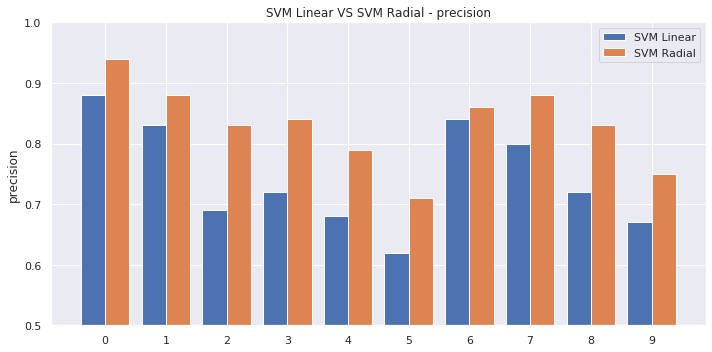

In [ ]:
comparePrecision(ytest, yfit_lin_no_PCA, yfit_rad_no_PCA, "SVM Linear", "SVM Radial", "precision")

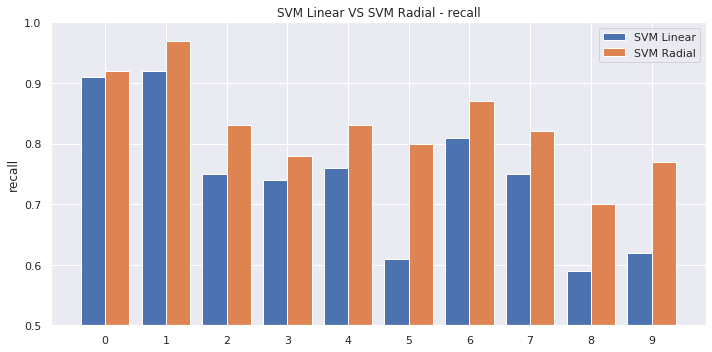

In [ ]:
comparePrecision(ytest, yfit_lin_no_PCA, yfit_rad_no_PCA, "SVM Linear", "SVM Radial", "recall")

# CNN

In this section we will train different convolutional neural networks, check their performances and select the most performant based on its prediction on the test set.

We consider directly CNN rather than other types of NN (e.g. with Dense Layers only) because of their capability to extract features from images with a limited number of parameters/weights. 

A common step to all the CNN architectures considered in this section is to reshape the input images in order to finally have a 4D tensor with the following dimension (num images, 28, 28, num channel).

Our baseline of performance for a classification is 83% obtained with SVM - if NN will have worst performances, then we will roll back to SVM for the final prediction.

The main takeaway of this section is that a CNN with 4 Convolutional layers performs better than SVM and other CNN architectures that we tested. We also tried to perform Data Augmentation but this attempt did not lead to any improvement.

In [27]:
import keras

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential

In [28]:
XtrainImg = [Xtrain[i,:].reshape(28,28) for i in range(0,Xtrain.shape[0])]

XtestImg = [Xtest[i,:].reshape(28,28) for i in range(0,Xtest.shape[0])]

In [29]:
XtrainImgTens = np.array(XtrainImg)

XtestImgTens = np.array(XtestImg)

In [30]:
num_classes = 10

In [31]:
# convert the target variable 
ytrain_cat = keras.utils.to_categorical(ytrain, num_classes)
ytest_cat = keras.utils.to_categorical(ytest, num_classes)

# specify the channel = 1
Xtrain_resized = XtrainImgTens.reshape(XtrainImgTens.shape[0], XtrainImgTens.shape[1], XtrainImgTens.shape[2], 1)
Xtest_resized = XtestImgTens.reshape(XtestImgTens.shape[0], XtestImgTens.shape[1], XtestImgTens.shape[2], 1)

In [32]:
input_shape = Xtrain_resized.shape[1:]

## Simple CNN

We will train now a Convolutional NN with 2 convolutional layers.

First attempt with learning rate 0.001 and 100 epoch.

I understand from Keras documentation (https://keras.io/api/optimizers/adadelta/) that Adadelta optimizer can automatically choose a learning rate, but at the same time there is the risk of having a learning rate equal to 1 during the last epochs of the training. This is the reason why I manually set anyway the learning rate.   

In [ ]:
def buildSimpleNN(modelInput, lr, input_shape, metric = 'accuracy'):
  """ 
  This function builds a simple NN 

  Input:
    - model: an instance of Sequential
    - lr: learning rate, default 0.001
    - metric: metric to be used for the optimizer, default accuracy

  Output:
    - model: the compiled version of the model 
  """

  # add first convolutional layer
  modelInput.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

  # add second convolutional layer
  modelInput.add(Conv2D(64, (3, 3), activation='relu'))

  # add one max pooling layer 
  modelInput.add(MaxPooling2D(pool_size=(2, 2)))

  # add one dropout layer
  modelInput.add(Dropout(0.125))

  # add flatten layer
  modelInput.add(Flatten())

  # add dense layer
  modelInput.add(Dense(128, activation='relu'))

  # add another dropout layer
  modelInput.add(Dropout(0.25))

  # add dense layer
  modelInput.add(Dense(num_classes, activation='softmax'))

  # complile the model and view its architecur
  modelInput.compile(loss=keras.losses.categorical_crossentropy,  optimizer=keras.optimizers.Adadelta(learning_rate = lr), metrics=[metric])

  return modelInput


In [ ]:
batch_size = 128
epochs = 100

model = Sequential()


model = buildSimpleNN(model, 0.001, input_shape, metric = 'accuracy')

# complile the model and view its architecur
model.compile(loss=keras.losses.categorical_crossentropy,  optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

#model.summary()

In [ ]:
history = model.fit(Xtrain_resized, ytrain_cat, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          validation_data=(Xtest_resized, ytest_cat))

accuracy = model.evaluate(Xtest_resized, ytest_cat, verbose=0)
print('Test accuracy:', accuracy[1])

In [33]:
def plotHistory(history):
  """
  This function plots the history of the loss and accuracy recorded during the training

  Input:
    - history: the output of model.fit
  """
  # Old run

  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


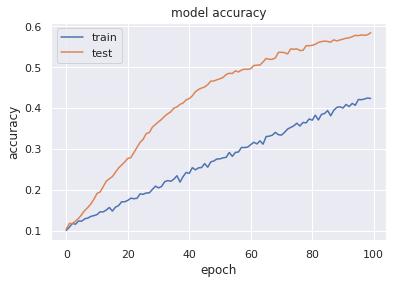

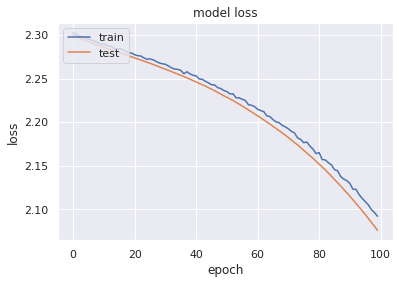

In [ ]:
plotHistory(history)

The above graph of the loss and the accuracy shows that the NN performs better on the test set rather than the training set. Although not completely expected, I understand that it can happen expecially when the Neural Network is not well trained yet. From the plot of the loss we see indeed that we should run the training for more epochs.  
Indeed the decrease in the loss is still ongoing and was a bit slow compared to the typical pattern we are used to.

3 action points:

\begin{itemize}
    \item increase the batch size to the max possible value considering that the training set has 9000 images because this will improve the accuracy of the backward propagation
    \item increase the learning rate from 0.001 to 0.01 to speed up the decrease of the loss
    \item increase the number of epochs for example to 3000

\end{itemize}

In [ ]:
batch_size = 9088 # increase the number of epochs - I am increasing them to a multiple of 128
epochs = 3000

model2 = Sequential()

model2 = buildSimpleNN(model2, 0.01, input_shape)

history2 = model2.fit(Xtrain_resized, ytrain_cat, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          validation_data=(Xtest_resized, ytest_cat))
accuracy2 = model2.evaluate(Xtest_resized, ytest_cat, verbose=0)
print('Test accuracy:', accuracy2[1])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


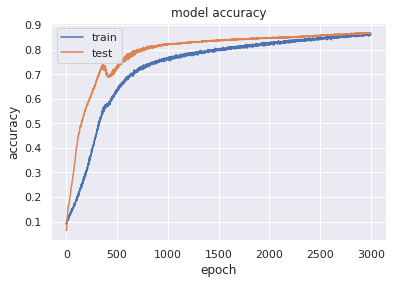

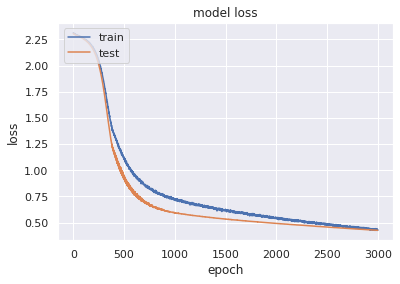

In [ ]:
plotHistory(history2)

The above graphs look fine in terms of trends and suggests probably the CNN could have been trained for other 500 epochs with no risk of overfitting.

### Assess performance

Create the dispersion matrix

In [ ]:
predictionTest2 = model2.predict(Xtest_resized)   # Get class probability vector for each sample
yPredictedTest2 = predictionTest2.argmax(axis=-1)  

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yPredictedTest2)

print(mat)

[[288   0   3   3   0   4   4   1   3   0]
 [  0 337   4   2   1   2   1   3   1   0]
 [  2   3 250   5   8   1   4   7   6   1]
 [  3   5  11 291   0  18   5   5   5   5]
 [  0   2   2   0 239   1   8   0   5  21]
 [  4   2   2  15   3 229   9   0   7   6]
 [  7   1   2   1   2   4 259   1   7   1]
 [  3   6   7   0   8   1   1 245   2  17]
 [  1  13   7  14   3  15   4   4 238   7]
 [  1   0   0   3  14   3   2  13   6 230]]


Check the classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yPredictedTest2))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       306
           1       0.91      0.96      0.94       351
           2       0.87      0.87      0.87       287
           3       0.87      0.84      0.85       348
           4       0.86      0.86      0.86       278
           5       0.82      0.83      0.83       277
           6       0.87      0.91      0.89       285
           7       0.88      0.84      0.86       290
           8       0.85      0.78      0.81       306
           9       0.80      0.85      0.82       272

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



The overall recall in this run with NN is 87 %, so better than the 83% we obtained with SVM.

5 and 8 are still the most difficult digits to be classified, while 9 is better identified compared to the SVM case.

### Data Augmentation


To further increase the accuracy on the validation without falling into overfit, we can try to perform data augmentation on the input images.

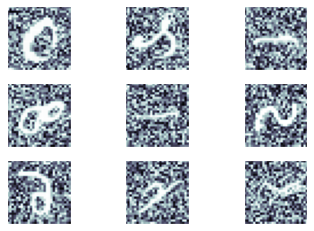

In [ ]:
#original images from the training set
fig, ax = plt.subplots(3, 3)
for i, axi in enumerate(ax.flat):
    axi.imshow(XtrainImg[i], cmap='bone')
    axi.set(xticks=[], yticks=[])#, xlabel= datasetTarget[i])
    

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Generator of augmented data
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   #zca_whitening=True
                                   )

validation_datagen = ImageDataGenerator()

In [ ]:
train_datagen.fit(Xtrain_resized)
validation_datagen.fit(Xtest_resized)

Below we can see an example of augmented images.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


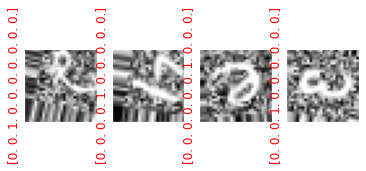

In [ ]:
# images post data augmentation
for batch, y in train_datagen.flow(Xtrain_resized, ytrain_cat, batch_size=4):
    for i in range(0, 4):
      ax = plt.subplot(140 + 1 + i)
      plt.imshow(batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
      ax.set(xticks=[], yticks=[])
      ax.set_ylabel(y[i], color='red')
    # show the plot
    plt.show()
    break

In [ ]:
train_batchsize = 9088
val_batchsize = 3072

In [ ]:
# Build iterators for both the train and the test set.

train_generator = train_datagen.flow(Xtrain_resized, ytrain_cat, batch_size=train_batchsize)
validation_generator = validation_datagen.flow(Xtest_resized, ytest_cat, batch_size=val_batchsize)

In [ ]:
nb_train_steps = 1 #train_generator.samples // train_generator.batch_size
nb_val_steps = 1 #validation_generator.samples // validation_generator.batch_size

Given that I expect the model to learn at a slower rate than before, I increased the number of epochs to 5000.

In [ ]:
model2_augm = Sequential()

model2_augm = buildNN(model2_augm, 0.01)


history2_augm = model2_augm.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_steps,
      epochs=5000,
      validation_data=validation_generator,
      validation_steps=nb_val_steps,
      verbose=0 #0
)

In [ ]:
model2_augm.save_weights("model2_augm-5000iter.h5")

In [ ]:
!mv model2_augm-5000iter.h5 gdrive/My\ Drive/DSTI-AI-assignment

In [ ]:
!ls gdrive/My\ Drive/DSTI-AI-assignment

10000iter-lr01.h5  model2_augm-5000iter.h5


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


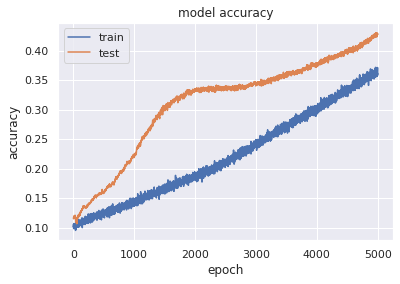

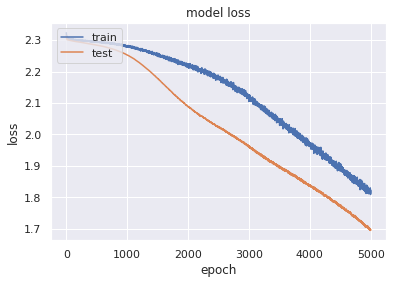

In [ ]:
plotHistory(history)

After having introduced the data augmentation, we observe wrt the training process: 

- the train became much slower in terms of time needed to effectively complete an epoch, most likely because the data augmentation part is done at runtime and is different in every epoch. Indeed we empirically observed that with Data Augmentation each epoch is completed approximately 3 times slower than without Data Augmentation 

- the accuracy of predictions on the test set are higher than accuracy of predicionts on training set. This might be compatible with the fact that the training set is augmented while the test set is not

- upon the completion of one epoch, the increase of the accuracy and the decrease of the loss are much smaller when using data augmentation compared to the case with no data augmentation. This makes me think that when using data augmentation we need to run much more epochs to achieve good precision


The last point above about the need to have a much higher number of epochs when training with data augmentation makes me think about the possibility to use transfer learning in order to start from an already trained NN and reduce the amount of epochs needed to have a well performing NN.

## Transfer learning with VGG16

As discussed before, to increase the accuracy of our model prediction without falling into overfitting, we may want to rely on data augmentation. At the same time data augmentation may require very long trainings (i.e. several epochs) to achieve good performances. A compromise could then be transfer learning which allows us to use a pre-trained CNN and train only the last layers which perform classification.

To adopt transfer learning:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain
3. Add some new, trainable layers on top of the frozen layers. 
4. Train the new layers on your dataset.


We will adopt this approach using VGG16. Unfortunately this attempt returned very poor results in terms of accuracy of the predictions.

In [70]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

import os

In [71]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

from keras.layers import Dense, Dropout, Flatten
from keras.models import Model

In [72]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape = (32,32,3))
base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [73]:
# Freeze the VGG 16 model
base_model.trainable = False

In [74]:
nb_classes = 10

In [75]:
flatten = Flatten()(base_model.output) # flatten from tensors to vector
dropout_1 = Dropout(0.125)(flatten)
fc_1 = Dense(100)(dropout_1) 
dropout_2 = Dropout(0.5)(fc_1)
predictions = Dense(nb_classes, activation="softmax", name='predictions')(dropout_2)

In [76]:
from keras.models import Model

In [77]:
modelVGG = Model( inputs = base_model.input, outputs=predictions)

In [78]:
from keras import optimizers

In [79]:
loss = 'categorical_crossentropy'
learning_rate = 0.0001
optimizer = optimizers.SGD ## optimizers.SGD ## optimizers.RMSprop ## optimizers.Adagrad ## optimizers.Adadelta
metrics = ['accuracy']

In [80]:
modelVGG.compile(loss=loss,
              optimizer=optimizer(learning_rate),
              metrics=metrics)

In [ ]:
# Generators without data Augmentation
train_datagen_VGG = ImageDataGenerator(
                                   preprocessing_function=preprocess_input_vgg 
                                   #zca_whitening=True
                                   )

validation_datagen_VGG = ImageDataGenerator(preprocessing_function=preprocess_input_vgg )

In [ ]:
# Generator with Data Augmentation
train_datagen_VGG_augm = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input_vgg 
                                   #zca_whitening=True
                                   )



VGG16 reqires input inmages to be at least 32 x 32 and with 3 channels, so we need to resize our image which are currently are 28 x 28.

For this purpose we will reshape images.

In [62]:
Xtrain_resized2_list = [cv2.resize(x, (32,32)).reshape((1,32,32,1)) for x in XtrainImgTens]

Xtest_resized2_list = [cv2.resize(x, (32,32)).reshape((1,32,32,1)) for x in XtestImgTens]

In [63]:
Xtrain_resized2 = np.concatenate(Xtrain_resized2_list)
Xtest_resized2 = np.concatenate(Xtest_resized2_list)

We will also copy the content of channel 1 to all others channels

In [112]:
Xtrain_resized3 = np.concatenate([Xtrain_resized2,Xtrain_resized2,Xtrain_resized2], axis = 3)
Xtest_resized3 = np.concatenate([Xtest_resized2,Xtest_resized2,Xtest_resized2], axis = 3)

In [117]:
Xtrain_resized3_preprop = preprocess_input(Xtrain_resized3)

Xtest_resized3_preprop = preprocess_input(Xtest_resized3)

In [92]:
loss = 'categorical_crossentropy'
learning_rate = 0.0001
optimizer = optimizers.Adadelta ## optimizers.SGD ## optimizers.RMSprop ## optimizers.Adagrad ## optimizers.Adadelta
metrics = ['accuracy']

In [ ]:
train_batchsize = 9088
val_batchsize = 3072

In [ ]:
nb_train_steps = 1 #train_generator.samples // train_generator.batch_size
nb_val_steps = 1 #validation_generator.samples // validation_generator.batch_size

As a first attempt, we will run VGG16 using transfer learning without using data augmentation. This will let us know wheter transfer learning with VGG16 is a valuable approach. 

In [ ]:
# Build iterators for both the train and the test set.

train_generator_VGG = train_datagen_VGG.flow(Xtrain_resized3, ytrain_cat, batch_size=train_batchsize)
validation_generator = validation_datagen_VGG.flow(Xtest_resized3, ytest_cat, batch_size=val_batchsize)

In [ ]:
historyVgg = modelVGG.fit( train_generator_VGG ,steps_per_epoch=nb_train_steps, 
          epochs=1000, 
          verbose=1, 
          validation_data=(Xtest_resized3, ytest_cat))


In [ ]:
accuracy = modelVGG.evaluate(Xtest_resized3, ytest_cat, verbose=0)

print(accuracy)

[2.3805789947509766, 0.08533333241939545]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


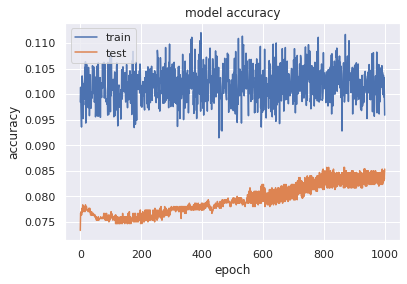

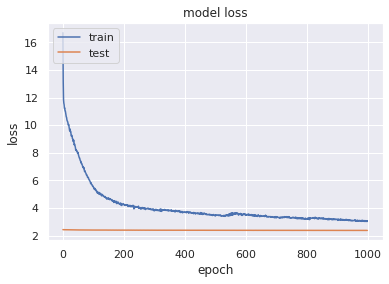

In [ ]:
plotHistory(historyVgg)

The above results are absolutely not acceptable. I reviewed various times the code to check whether I did some mistake in setting up VGG16, but I could not spot any.

Probably the above poor results are due to the fact that features learnt by VGG16 when trained on ImageNet are not relevant with our dataset. 

Given the above poor results, I will not test further VGG16.

## Alternative CNN Architecture

We now try to run a CNN architecture with 4 convolutional layers. Indeed more hidden layers can help in general to increase the accuracy of the predictions of the NN, without overfitting. In the specific case of Convolutional layers, more convolutional layers increase also the area of the image that each neuron in the outer layers can "cover.

We tried even in this case to train the CNN on the original training set and an augmented version.

It turned out that CNN trained on the original training set is the most performing classifier compared to the classifiers that we explored in our previous sessions. Even in this case Data Augmentation did not bring any benefit.

In [ ]:
input_shape = Xtrain_resized.shape[1:]

print(input_shape)

(28, 28, 1)


In [38]:
from keras.layers import BatchNormalization, GlobalAveragePooling2D

In [39]:
def buildAlternativeNN():

  model = Sequential()

  model.add(Conv2D(64, kernel_size=3, padding="same", activation="relu", input_shape=input_shape))
  model.add(Conv2D(64, kernel_size=3, padding="same", activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.05))

  model.add(Conv2D(128, kernel_size=3, padding="same", activation="relu"))
  model.add(Conv2D(128, kernel_size=3, padding="same", activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.05))

  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.125))
  model.add(Dense(100))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation="softmax", name="predictions"))

  return model

In [ ]:
model5 = buildAlternativeNN()


In [ ]:
model5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)      

In [ ]:
model5.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adadelta(lr=0.01),
            metrics=['accuracy'])

As a first attempt, I will run this new NN using the same optimizer, learning rate and number of epochs I used in the Simple NN section.

In [ ]:
batch_size = 9088

history5 = model5.fit(Xtrain_resized, ytrain_cat, 
          batch_size=batch_size,
         epochs=3000,
         validation_data=(Xtest_resized, ytest_cat))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


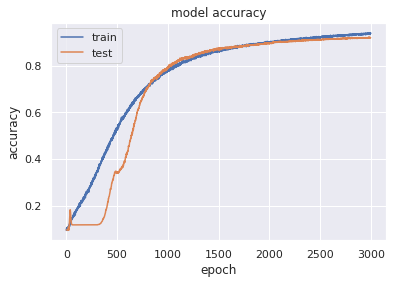

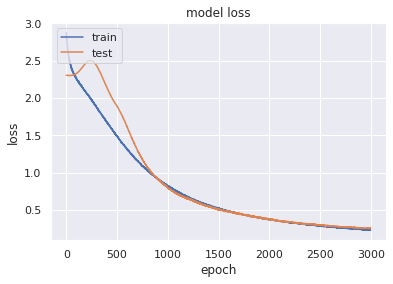

In [ ]:
plotHistory(history)

Apart from the first 700 epochs of training where the trend of the loss function was not the "ideal" one, the loss function decreased consistently during the training. We will further train the model given that it seems there is still room to train the model with no overfit.

### Additional training

We will try to train the model for additional 2000 epochs.

In [ ]:
history5_5000epoch = model5.fit(Xtrain_resized, ytrain_cat, 
          batch_size=batch_size,
         epochs=2000,
         validation_data=(Xtest_resized, ytest_cat))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


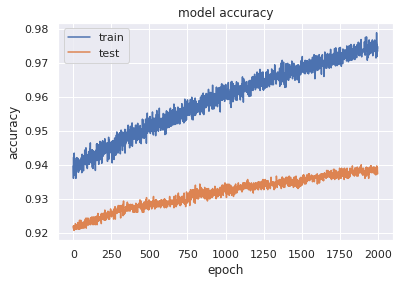

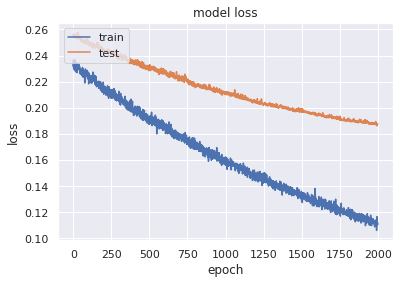

In [ ]:
plotHistory(history5_5000epoch)

We see quite many oscillations in the loss function, probably it would have been worth to set a smaller learning rate.

Looking at the trend of the loss function, it looks like there is still room to train the NN for some more epochs. 

Running other 1000 epochs with smaller learning rate.

In [ ]:
from keras.callbacks import LearningRateScheduler

In [ ]:
def scheduler_lr001(epoch, lr):
  return 0.001

myCallback = LearningRateScheduler(scheduler_lr001)

In [ ]:
history5_6000epoch = model5.fit(Xtrain_resized, ytrain_cat, 
          batch_size=batch_size,
         epochs=1000,
         callbacks = myCallback,
         validation_data=(Xtest_resized, ytest_cat))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


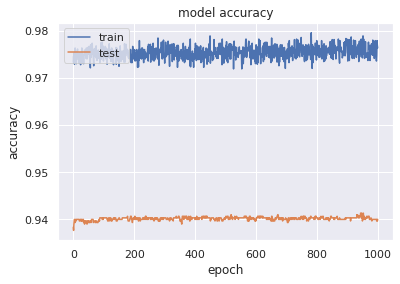

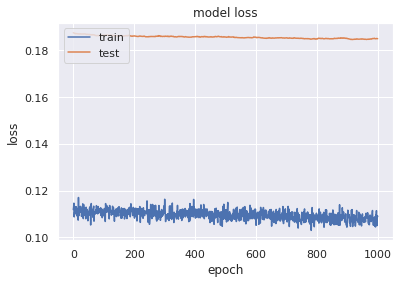

In [ ]:
plotHistory(history5_6000epoch)

Actually there was no significant decrease of the loss function, no need to further train the CNN. 

### Assess performances



In this section we will check more closely the overall performances of the CNN and compare them with other models we tested before.

On the test set the CNN we tested is able to classify images with an accuracy of 92 %, the highest so far.

In [ ]:
accuracy5 = model5.evaluate(Xtest_resized, ytest_cat, verbose=0)

print(accuracy5) #

[0.2574433982372284, 0.9210000038146973]


In [ ]:
predictionTest5 = model5.predict(Xtest_resized)   # Get class probability vector for each sample
yPredictedTest5 = predictionTest5.argmax(axis=-1)  

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yPredictedTest5)

print(mat)

[[290   0   3   0   0   4   5   0   4   0]
 [  0 343   3   0   1   0   1   3   0   0]
 [  2   5 261   7   1   3   0   1   5   2]
 [  0   0   6 321   0  12   0   3   3   3]
 [  0   2   0   0 268   1   2   0   0   5]
 [  1   0   0   2   1 260   2   0   6   5]
 [  6   5   0   0   0   5 267   0   2   0]
 [  0   5   5   6   6   0   0 263   0   5]
 [  3   7   3   3   3  14   5   0 255  13]
 [  1   1   1   3  13   2   2  12   2 235]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yPredictedTest5))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       306
           1       0.93      0.98      0.95       351
           2       0.93      0.91      0.92       287
           3       0.94      0.92      0.93       348
           4       0.91      0.96      0.94       278
           5       0.86      0.94      0.90       277
           6       0.94      0.94      0.94       285
           7       0.93      0.91      0.92       290
           8       0.92      0.83      0.87       306
           9       0.88      0.86      0.87       272

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



Overall performances improved in terms of precision and recall. The digit 8 is still problematic, it is misclassified with 5 or 9.

The digit 9 as well is misclassified as 4 or 7.

The digit 5 is not anymore among the worst classified digit.

In the next section we will check a couple of this wrongly classified images for 8 and 9.

### Check the wrongly classified images

We will double check the images which are 8 but were classified as 9.

In [ ]:
check5 = pd.DataFrame({"Real":ytest, "predicted":yPredictedTest5})

In [ ]:
wrongDetection = check5[(check5["Real"] == 8) & (check5["predicted"] == 9)].index

In [ ]:
wrongDetection.shape

(13,)

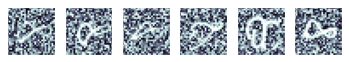

In [ ]:
displayImgFromNumpy2(Xtest[wrongDetection[:6]],28,28)

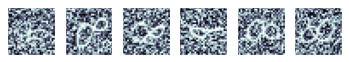

In [ ]:
displayImgFromNumpy2(Xtest[wrongDetection[6:]],28,28)

Some of the above images look really blurry and the shape of the 8 is not much clear. It is quite understandable that such images are difficult to be classified and I do not see a clear way to address this issue.

### Data augmentation

In this section we will train the same NN but on an augmented version of the training set to check if it is possible to have higher precision in the predictions of the test set.

In [ ]:
train_datagen5_light = ImageDataGenerator(rotation_range=10,
                                   zoom_range=0.05,
                                   horizontal_flip=True,
                                   #vertical_flip= True,
                                   #shear_range=0.1,
                                   #fill_mode='nearest',
                                   #zca_whitening=True
                                   )

#validation_datagen5 = ImageDataGenerator()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


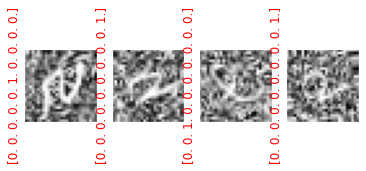

In [ ]:
# images post data augmentation
for batch, y in train_datagen5_light.flow(Xtrain_resized, ytrain_cat, batch_size=4):
    for i in range(0, 4):
      ax = plt.subplot(140 + 1 + i)
      plt.imshow(batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
      ax.set(xticks=[], yticks=[])
      ax.set_ylabel(y[i], color='red')
    # show the plot
    plt.show()
    break

In [ ]:
train_batchsize = 4500
val_batchsize = 3000

In [ ]:
# Build iterators for both the train and the test set.

train_generator5_light = train_datagen5_light.flow(Xtrain_resized, ytrain_cat, batch_size=train_batchsize)
#validation_generator5 = validation_datagen5.flow(Xtest_resized, ytest_cat, batch_size=val_batchsize)

In [ ]:
nb_train_steps =2 #train_generator5.samples // train_generator5.batch_size
nb_val_steps =1 #validation_generator5.samples // validation_generator5.batch_size

In [ ]:
model5_augTest_light = buildAlternativeNN()

model5_augTest_light.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adadelta(lr=0.005),
            metrics=['accuracy'])

In [ ]:
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

I define below a scheduler for the learning rate that gradually increases its value during the first 200 epochs and decreases its value in the second half of the training.

Additionally we define a callback to save every 5000 batches the model and its weight. This is particularly useful given that I used Colab and there is always the risk of a disconnection.

In [ ]:
def scheduler5_soft_aug(epoch, lr):
  """
  This function returns the learning rate to be used in a Keras Scheduler
  """
  if epoch <= 200:
    result = 0.01*(epoch/200)
  elif (epoch > 200) and (epoch < 3000):
    result = 0.01
  elif (epoch >= 3000 and epoch < 4000):
    result = 0.005
  elif epoch >= 4000:
    result = 0.001

  return result




In [ ]:
my_callbacks5_soft_aug = [
    
    ModelCheckpoint(filepath='/content/gdrive/My Drive/DSTI-AI-assignment/model5_augTest_light.{epoch:02d}', save_freq = 500),
    LearningRateScheduler(scheduler5_soft_aug)
]


In [ ]:
history5_augmTest_light = model5_augTest_light.fit(
      train_generator5_light,
      steps_per_epoch=nb_train_steps,
      epochs=5000,
      validation_data=(Xtest_resized, ytest_cat),
      #validation_steps=nb_val_steps,
      callbacks=my_callbacks5_soft_aug,
      verbose=2 #0
)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


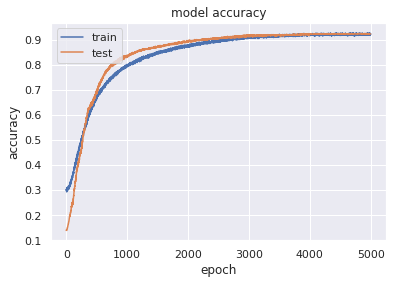

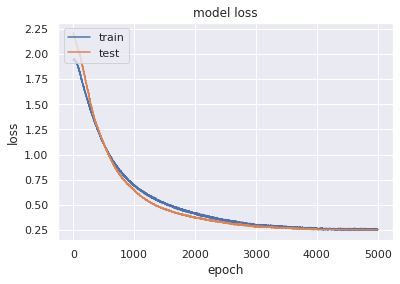

In [ ]:
plotHistory(history5_augmTest_light)

From the above plots I infer that it is worth to try to push further the training.

Train additional 1500 epochs, setting a learning rate of 0.001

In [ ]:
def scheduler5_shortRun(epoch, lr):
  
    return 0.001


In [ ]:
my_callbacks5_soft_aug_short = [
    
    ModelCheckpoint(filepath='model5_augTest_light.{epoch:02d}', save_freq = 500),
    LearningRateScheduler(scheduler5_shortRun)
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
history5_augmTest_light = model5_augTest_light.fit(
      train_generator5_light,
      steps_per_epoch=nb_train_steps,
      epochs=1500,
      validation_data=(Xtest_resized, ytest_cat),
      #validation_steps=nb_val_steps,
      callbacks=my_callbacks5_soft_aug_short,
      verbose=2 #0
)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


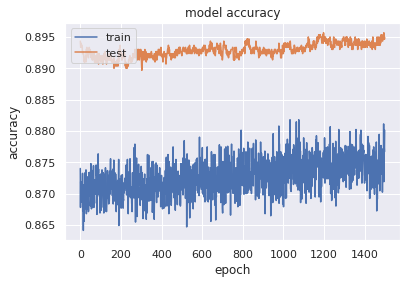

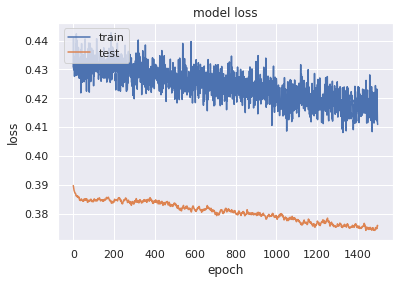

In [ ]:
plotHistory(history5_augmTest_light)

The above plots indicate we cannot further improve the performance of our CNN using Data Augmentation. Given that the obtained accuracy on the test set is lower than when not using Data Augmentation, I will not further use this technique.

# Predict on test.csv

Based on the analysis done so far, the model that better classified the images in the test set is the CNN tested in the section "Alternative CNN Architecture" with no Data Augmentation.

To classify images on test.csv, I then trained the selected CNN on the whole train.csv dataset without Data Augmentation.

In [ ]:
XFinalImg = [datasetData[i,:].reshape(28,28) for i in range(0,datasetData.shape[0])]

In [ ]:
XFinalTens = np.array(XFinalImg)

In [ ]:
num_classes = 10

In [ ]:
# convert the target variable 
yFinal = keras.utils.to_categorical(datasetTarget, num_classes)

# specify the channel = 1
XFinal_resized = XFinalTens.reshape(XFinalTens.shape[0], XFinalTens.shape[1], XFinalTens.shape[2], 1)

In [ ]:
input_shape = XFinal_resized.shape[1:]

In [ ]:
batch_size = 4096 # here I lowered the batch size because I received an error related to Colab not able to process such a high batch size
epochs = 5000

In [ ]:
modelFinal = buildAlternativeNN()

modelFinal.compile(loss=keras.losses.categorical_crossentropy,  optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

In [ ]:
modelFinal.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       1

In [34]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [40]:
def schedulerFinal(epoch, lr):
  """
  This function induces a slow increase of the learning rate in the early stages of the training, and
  a decrease in the final stages as well 
  """
  if epoch <= 200:
    result = 0.01*(epoch/200)
  elif (epoch > 200) and (epoch < 3000):
    result = 0.01
  elif (epoch >= 3000 and epoch < 4000):
    result = 0.005
  elif epoch >= 4000:
    result = 0.001

  return result

The below call back ensures that the model is saved every 500 batches and that the learning rate changes according to the function above.

In [ ]:
my_callbacksFinal = [    
    ModelCheckpoint(filepath='/content/gdrive/My Drive/DSTI-AI-assignment/modelFinal.{epoch:02d}', save_freq = 500),
    LearningRateScheduler(schedulerFinal)
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


In [ ]:
historyFinal = modelFinal.fit(XFinal_resized, yFinal, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          callbacks=my_callbacksFinal
          #validation_data=(Xtest_resized, ytest_cat)
          )

dict_keys(['loss', 'accuracy', 'lr'])


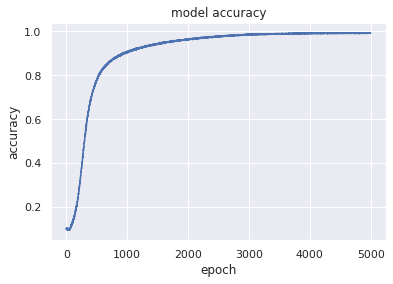

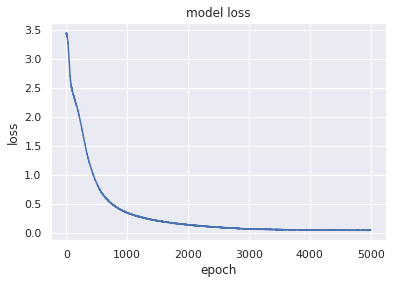

In [ ]:
# list all data in history
print(historyFinal.history.keys())
# summarize history for accuracy
plt.plot(historyFinal.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(historyFinal.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

The above plot of the loss function seems to confirm the training is completed.  

In [ ]:
valImg = [val[i,:].reshape(28,28) for i in range(0,val.shape[0])]

In [ ]:
valImgTens = np.array(valImg)

In [ ]:
val_resized = valImgTens.reshape(valImgTens.shape[0], valImgTens.shape[1], valImgTens.shape[2], 1)

Classify images on test.csv.

In [ ]:
predictionValFinal = modelFinal.predict(val_resized)   
yPredictedValFinal = predictionValFinal.argmax(axis=-1) 

In [ ]:
 yPredictedValFinal[:6]

array([6, 6, 8, 4, 3, 9])

In [ ]:
yPredictedValFinal_DF = pd.DataFrame({"Id": np.arange(0,50000), "Category": yPredictedValFinal})

In [ ]:
yPredictedValFinal_DF.to_csv("/content/gdrive/My Drive/DSTI-AI-assignment/prediction-Sonnellini.csv", index = False)

# Conclusions

In this analysis we considered various models to perform the classification of the images of the modified MINST dataset.
Based on the error of predictions on a test set of images, the model that better classified the images is the CNN tested in the section Alternative CNN Architecture (with no Data Augmentation). 
Kaggle reports that the final precision of predictions on test.csv is approximately 0.95.

To improve the performances of the various CNN we tested, we tried mainly to use Data Augmentation, but this did never turn out to bring any benefit.  

I list below possible alternative/additional steps that could be worth to attempt - none of them was performed for reason of time: 

\begin{itemize}
\item Tweak the CNN: All the CNN we used had a Dense layer with approximately 100 neurons. A very simple attempt we could have done is to increase the number of neurons (e.g. double it) and check whether this could have led to any benefit 
\item Use other NN architectures: in terms of alternative architectures I believe it is not worth to try more complex CNN architectures (e.g. with more convolutional layers) given that images in the dataset are of small dimensions and I do not see the need to further expand the area that the neuron of the last convolutional layers "sees". However it could be worth to train a NN made of dense layers only. I did not went through this option in first place because I considered CNN better suited than Dense Layers to classify images. On the other hand, given the small dimension of each image of the dataset, the capability of CNN to map areas of an image with a limited number of neurons (and then parameters) may not be needed in this case and Dense Layers with few neurons (e.g. few hundreds) could have performed well. I did not explore this option due to the lack of time
\item Extract Features: we could use the trained CNN without the last layer as an extractor of features and run a classifier (e.g. SVM) on top of it. I did not went through this option mainly for reasons of time and because I expected it to give worse results than the full/standard CNN, but it might be worth to attempt it
\item Treat/Remove the noise: I am aware there are various techniques to denoise images (for example using NN as well). It could be interesting to train CNNs on both the noisy original training set vs a cleaned version, perform classification on a cleaned test image and check if accuracy of predictions have any benefit
\end{itemize}